# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [ ]:
# code here
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import time
import torch.optim.lr_scheduler as lr_scheduler

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [ ]:
# code here
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])
batch_size = 64
train_x = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_x = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainloader), len(testloader), len(train_x), len(test_x)

(782, 157, 50000, 10000)

LABEL : 6
tensor(0.) tensor(1.)
782 782
torch.Size([64, 3, 32, 32])
torch.Size([64]) tensor([5, 4, 0, 6, 3, 2, 9, 0, 3, 3])


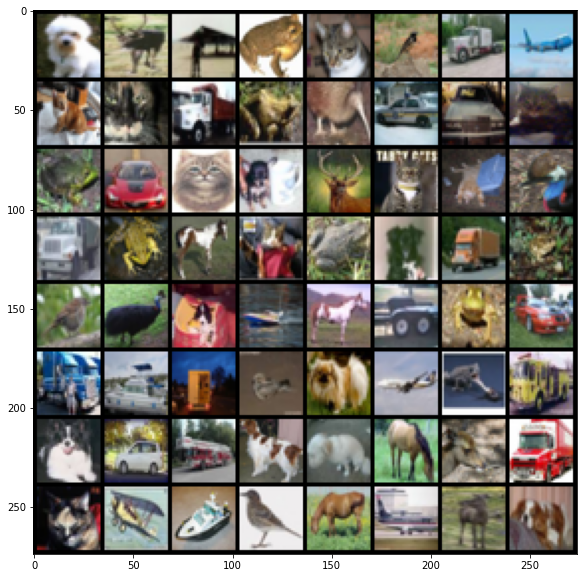

plane   car  bird   cat  deer


In [ ]:
# let's have a look at the dataset

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(train_x[0][0])
print("LABEL :", train_x[0][1])

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))
print(len(trainloader), len(dataiter))
print(images.shape)
print(labels.shape, labels[:10])

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[i] for i in range(5)))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [ ]:
class MLPAutoEncoder(nn.Module):
    # code
    def __init__(self,shape = 3072, no_of_output=32):
        super(MLPAutoEncoder,self).__init__()
        # code here
        self.encoder = nn.Sequential(
            nn.Linear(shape, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, no_of_output)
        )
        self.decoder = nn.Sequential(
            nn.Linear(no_of_output, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, shape),
            nn.Sigmoid()
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        return decoded


class ComboAutoEncoder(nn.Module):
    # code
    def __init__(self,shape = 3072, no_of_output=32):
        super(ComboAutoEncoder,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8*16*16

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16*8*8

            nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4*4*4

            nn.Flatten(),
            nn.Linear(4*4*4, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 4*4*4),
            nn.Unflatten(1, torch.Size([4,4,4])),
            
            # print("REACH1"),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # print("REACH2"),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # print("REACH3"),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1),
            # print("REACH4"),
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        # print("REACH"),
        encoded = self.encoder(img)
        # print("REACHED"),
        decoded = self.decoder(encoded)
        # print("REACHED VAL")
        return decoded


class CNNAutoEncoder(nn.Module):
    # code
    def __init__(self):
        # code here
        super(CNNAutoEncoder,self).__init__() 
        # super(EncoderDecoder32,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
            nn.ReLU(),
            nn.Conv2d(8, 6, kernel_size=4, stride=2, padding=1), #6*8*8
            nn.ReLU(),
            nn.Conv2d(6, 2, kernel_size=4, stride=2, padding=1), #2*4*4
            # nn.Flatten()
        )
        self.decoder = nn.Sequential(
            # nn.Unflatten(1, torch.Size([2,4,4])),
            nn.ConvTranspose2d(2, 6, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 9, kernel_size=5, stride=2, padding=0), #9*13*13    (32-5)/2
        #     nn.ReLU(inplace=True),
        #     # nn.MaxPool2d(kernel_size=2, stride=2), # 3*16*16

        #     nn.Conv2d(9, 24, kernel_size=5, stride=2, padding=1), #24*6*6  (13-3+2)/2
        #     nn.ReLU(inplace=True),
        #     # nn.MaxPool2d(kernel_size=2, stride=2), # 3*8*8

        #     nn.Conv2d(24, 8, kernel_size=3, stride=2, padding=0), #8*2*2  (5-3+2)/2
        #     # nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=1), # 3*4*4
            
        #     # nn.Conv2d(8, 2, kernel_size=3, stride=1, padding=1), #2*4*4
        #     # nn.ReLU(inplace=True),
        #     # nn.MaxPool2d(kernel_size=2, stride=1), # 2*4*4
        #     nn.Flatten(),
        # )
        # self.decoder = nn.Sequential(
        #     nn.Unflatten(1, torch.Size([8,2,2])),
        #     # print("REACHED")
        #     # nn.Upsample(scale_factor=2, stride=1, mode='nearest'),
        #     nn.ConvTranspose2d(8, 24, kernel_size=2, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),
        #     nn.ConvTranspose2d(24, 9, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),
        #     nn.ConvTranspose2d(9, 3, kernel_size=3, stride=1, padding=1),
        #     # nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),
        #     # nn.Conv2d(9, 3, kernel_size=3, stride=2, padding=1),
        #     nn.ReLU()
        # )

    def forward(self, x):
        x = self.encoder(x)
        # print("REACHED", x.shape)
        x = self.decoder(x)
        # print("REACHED", x.shape)
        return x

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [ ]:
loss_mse = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelCNN = CNNAutoEncoder().to(device)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.01, weight_decay=1e-5)

# modelcombo = ComboAutoEncoder().to(device)

num_epochs = 10

outputs_cnn = []
for epoch in range(num_epochs):
    start = time.process_time()
    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.to(device)
        # print(images.shape)
        output = modelCNN(images)
        # print(images.shape, output.shape)
        loss = loss_mse(output, images)
        loss.backward()
        optimizer.step()
    print("At epoch :",epoch, "Time taken :", time.process_time() - start)
    print('Epoch [{}/{}] , Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    outputs_cnn.append((epoch, float(loss.item()), images.cpu().detach().numpy(), output.cpu().detach().numpy()))

At epoch : 0 Time taken : 5.818793167000024
Epoch [1/10] , Loss: 0.0128
At epoch : 1 Time taken : 5.825463395999975
Epoch [2/10] , Loss: 0.0142
At epoch : 2 Time taken : 5.8061062419999985
Epoch [3/10] , Loss: 0.0123
At epoch : 3 Time taken : 5.927873525999985
Epoch [4/10] , Loss: 0.0145
At epoch : 4 Time taken : 5.757411248999972
Epoch [5/10] , Loss: 0.0150
At epoch : 5 Time taken : 5.843144170000016
Epoch [6/10] , Loss: 0.0159
At epoch : 6 Time taken : 5.865991909999991
Epoch [7/10] , Loss: 0.0147
At epoch : 7 Time taken : 5.821686117000013
Epoch [8/10] , Loss: 0.0163
At epoch : 8 Time taken : 5.811866265999981
Epoch [9/10] , Loss: 0.0188
At epoch : 9 Time taken : 5.822367744999951
Epoch [10/10] , Loss: 0.0135


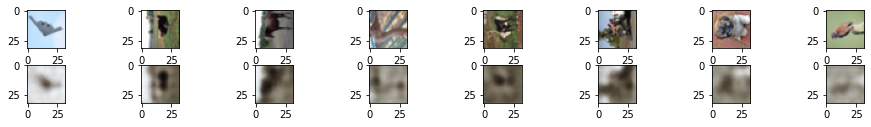

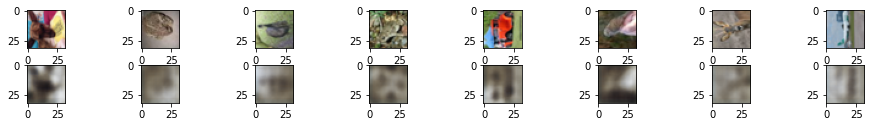

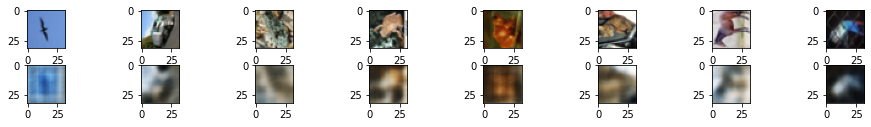

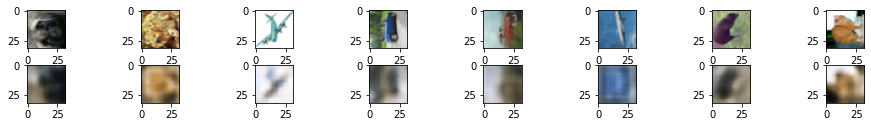

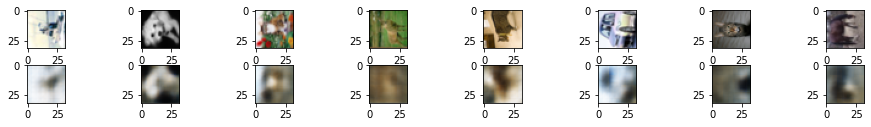

In [ ]:
# # print(len(outputs))
# print(outputs[0][2].shape)
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(15, 2))
    plt.gray()
    imgs = outputs_cnn[k][2]
    recon = outputs_cnn[k][3]
    # print(f"AT EPOCH {k}")
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.imshow(item.T)
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.subplots_adjust(wspace=2, hspace=0)
        plt.imshow(item.T)
lst1 = lst1[::-1]
lst2 = lst2[::-1]
# dataiter = iter(testloader)
# images, labels = next(dataiter)
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# # print(outputs_cnn)
# decoded_imgs = outputs_cnn[0][2].cpu().detach()

# # self.transform = transforms.Compose([transforms.ToTensor()])
# imshow(torchvision.utils.make_grid(decoded_imgs))

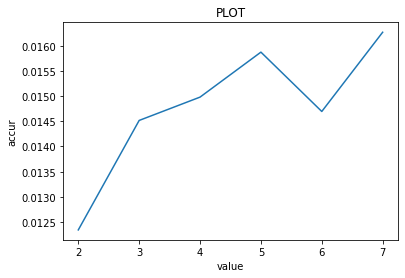

In [ ]:
outputs_cnn = np.array(outputs_cnn)
lst1 = outputs_cnn[2:8, 0]
lst2 = outputs_cnn[2:8, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

In [ ]:
# code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelcombo = ComboAutoEncoder().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(modelcombo.parameters(), lr=1e-3, weight_decay=1e-5)
num_epochs = 10
outputs_combo = []
loss = 0

for epoch in range(num_epochs):
    start = time.process_time()
    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.to(device)
        
        output = modelcombo(images)
        # print(images.shape, output.shape)
        loss = loss_c(output, images)
        loss.backward()
        optimizer.step()
    print("At epoch :",epoch, "Time taken :", time.process_time() - start)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_combo.append((epoch, float(loss.item()), images.cpu().detach().numpy(), output.cpu().detach().numpy()))

At epoch : 0 Time taken : 7.219752261999986
Epoch:1, Loss:0.0244
At epoch : 1 Time taken : 7.095797333000007
Epoch:2, Loss:0.0190
At epoch : 2 Time taken : 7.0950173470000095
Epoch:3, Loss:0.0171
At epoch : 3 Time taken : 7.076938883000025
Epoch:4, Loss:0.0167
At epoch : 4 Time taken : 7.094566849999978
Epoch:5, Loss:0.0188
At epoch : 5 Time taken : 7.143059324999967
Epoch:6, Loss:0.0150
At epoch : 6 Time taken : 7.045782835000011
Epoch:7, Loss:0.0138
At epoch : 7 Time taken : 7.292026312000019
Epoch:8, Loss:0.0155
At epoch : 8 Time taken : 7.207015199999944
Epoch:9, Loss:0.0190
At epoch : 9 Time taken : 7.105344425999988
Epoch:10, Loss:0.0141


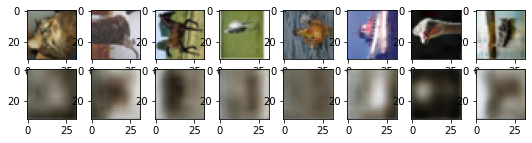

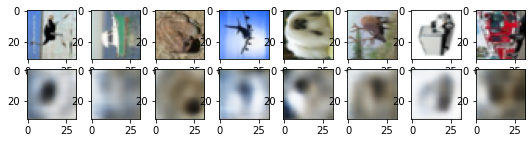

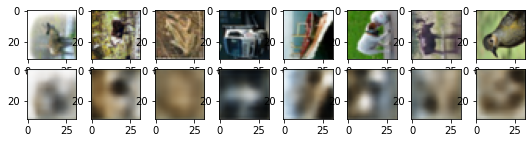

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs_combo[k][2]
    recon = outputs_combo[k][3]
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        item = item.reshape(-1, 3, 32, 32) # -> use for Autoencoder_Linear
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        # print(item.shape)
        if i >= 8: break
        plt.subplot(2, 8, 9+i) 
        item = item.reshape(-1, 3, 32, 32) # -> use for Autoencoder_Linear
        plt.imshow(item[0].T)

# dataiter = iter(testloader)
# images, labels = next(dataiter)
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# # print(outputs_cnn)
# decoded_imgs = outputs_cnn[0][2].cpu().detach()

# # self.transform = transforms.Compose([transforms.ToTensor()])
# imshow(torchvision.utils.make_grid(decoded_imgs))

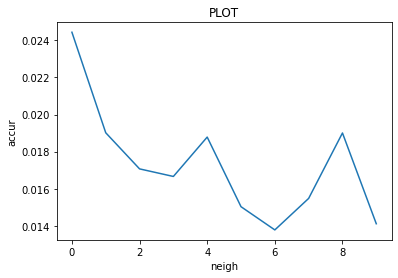

In [ ]:
outputs_combo = np.array(outputs_combo)
lst1 = outputs_combo[:, 0]
lst2 = outputs_combo[:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('neigh')
plt.title('PLOT')
plt.show()

In [ ]:
# # code here
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = MLPAutoEncoder().to(device)
# modelCNN = CNNAutoEncoder().to(device)
# modelcombo = ComboAutoEncoder().to(device)
# # print(model.summary())
# # print(modelCNN.summary())
# # print(modelcombo.summary())
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPAutoEncoder().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

num_epochs = 10
outputs = []
loss = 0
for epoch in range(num_epochs):
    start = time.process_time()
    for (images, labels) in trainloader:
        optimizer.zero_grad()
        images = images.view(-1, 3*32*32).to(device)
        # images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = loss_c(output, images)
        loss.backward()
        optimizer.step()
    print("At epoch :",epoch, "Time taken :", time.process_time() - start)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, float(loss.item()), images.cpu().detach().numpy(), output.cpu().detach().numpy()))

At epoch : 0 Time taken : 6.812962282999999
Epoch:1, Loss:0.0300
At epoch : 1 Time taken : 5.772973967999999
Epoch:2, Loss:0.0241
At epoch : 2 Time taken : 5.7171601740000035
Epoch:3, Loss:0.0244
At epoch : 3 Time taken : 5.7552105130000015
Epoch:4, Loss:0.0208
At epoch : 4 Time taken : 5.789019289000002
Epoch:5, Loss:0.0238
At epoch : 5 Time taken : 5.735996336999996
Epoch:6, Loss:0.0252
At epoch : 6 Time taken : 5.550037203000002
Epoch:7, Loss:0.0196
At epoch : 7 Time taken : 5.738353941999996
Epoch:8, Loss:0.0248
At epoch : 8 Time taken : 5.756590698000004
Epoch:9, Loss:0.0248
At epoch : 9 Time taken : 5.767318233000005
Epoch:10, Loss:0.0176


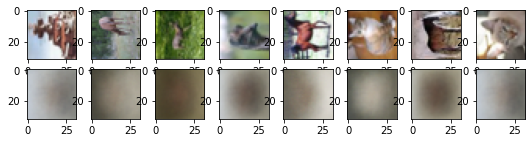

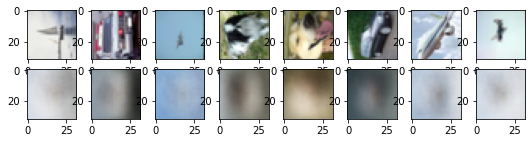

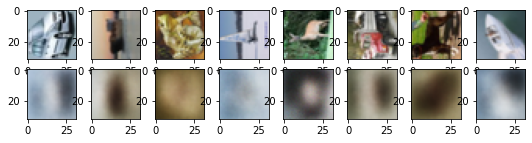

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][2]
    recon = outputs[k][3]
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        item = item.reshape(-1, 3, 32, 32) 
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i) 
        item = item.reshape(-1, 3, 32, 32) 
        plt.imshow(item[0].T)

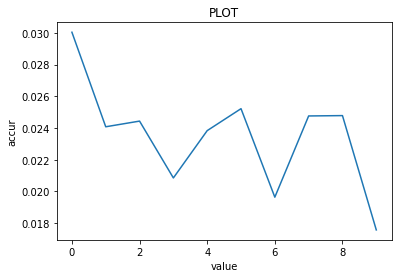

In [ ]:
outputs = np.array(outputs)
lst1 = outputs[:, 0]
lst2 = outputs[:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

In [ ]:
# Utilize the following code
#--------------MLP--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------Combo--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------CNN--------------#
# dataiter = iter(testloader)
# images, labels = next(dataiter)
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs =  outputs[9][2]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
# analysis, plots and tabulations here

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

If the representation size in a CNN auto-encoder is increased beyond a certain point, it can lead to overfitting to the training data, resulting in little improvement in reconstruction quality. Furthermore, larger representation sizes require more model parameters and computational resources, making the training process slower and more challenging to optimize.

Epoch:1, Loss:0.0401
Epoch:2, Loss:0.0354
Epoch:3, Loss:0.0264
Epoch:4, Loss:0.0260
Epoch:5, Loss:0.0309
Epoch:6, Loss:0.0258
Epoch:7, Loss:0.0280
Epoch:8, Loss:0.0290
Epoch:9, Loss:0.0323
Epoch:10, Loss:0.0315


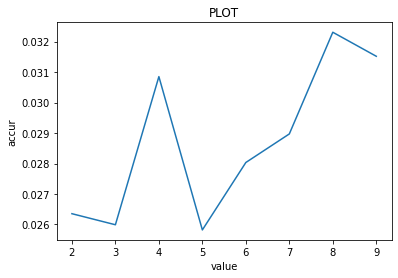

(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


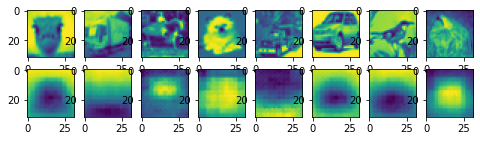

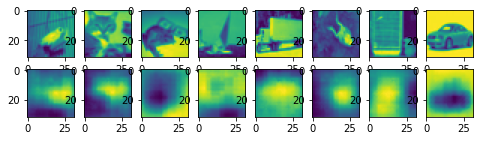

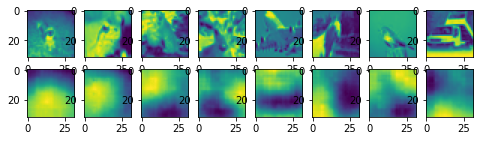

Reconstructed image


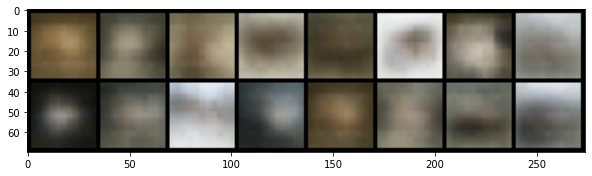

In [ ]:
# code and analysis here
class EncoderDecoder10(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder10,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 9, kernel_size=2, stride=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(9, 27, kernel_size=6, stride=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(27, 10, kernel_size=3, stride=3), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 1),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([10,1,1])),
            # nn.MaxUnpool2d(2, 1),
            nn.ConvTranspose2d(10, 27, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(27, 9, kernel_size=4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, kernel_size=4, stride=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self,img):
        # code here
        # print("REACH"),
        encoded = self.encoder(img)
        # print("REACHED", encoded.shape),
        decoded = self.decoder(encoded)
        # print("REACHED VAL", decoded.shape)
        return decoded

    
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model10 = EncoderDecoder10().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model10.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs10 = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1,3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model10(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs10.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

outputs10 = np.array(outputs10)
lst1 = outputs10[:8, 0]
lst2 = outputs10[:8, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(8, 2))
    imgs = outputs10[k][2].numpy()
    recon = outputs10[k][3].numpy()
    print(imgs.shape, recon.shape)
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.imshow(item[0])

images = outputs10[9][2]
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs = outputs10[9][3]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
# # code and analysis here
# class EncoderDecoder32(nn.Module):
#     # code
#     def __init__(self):
#         super(EncoderDecoder32,self).__init__() 
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
#             nn.ReLU(),
#             nn.Conv2d(8, 6, kernel_size=4, stride=2, padding=1), #6*8*8
#             nn.ReLU(),
#             nn.Conv2d(6, 2, kernel_size=2, stride=1, padding=1), #2*8*8
#             nn.ReLU(),
            
            
#         )
#         self.pool=nn.MaxPool2d(2,padding=0,stride=2,return_indices=True)
#         self.flat=nn.Flatten()
#         self.unflat=nn.Unflatten(1, torch.Size([2,4,4]))
#         self.unpool=nn.MaxUnpool2d(2,padding=0,stride=2)
        

#         self.decoder = nn.Sequential(
            
            
#             nn.ConvTranspose2d(2, 6, kernel_size=4, stride=1, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(6, 8, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self,img):
#         # code here
#         # print("REACH"),
#         encoded = self.encoder(img)
        
#         encoded,indices=self.pool(encoded)
#         print("REACHED", encoded.shape)
#         encoded=self.flat(encoded)
#         decoded=self.unflat(encoded)
#         decoded=self.unpool(decoded,indices)
#         decoded = self.decoder(decoded)
#         print("REACHED VAL", decoded.shape)
#         return decoded

        

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model32 = EncoderDecoder32().to(device)
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model32.parameters(), lr=1e-3, weight_decay=1e-5)

# num_epochs = 10
# outputs32 = []
# loss = 0
# for epoch in range(num_epochs):
#     for (images, labels) in trainloader:
#       optimizer.zero_grad()
#       # images = images.view(-1,3,32,32).to(device)
#       images = images.to(device)
#       labels = labels.to(device)
#       output = model32(images)
#       loss = loss_c(output, images)
#       loss.backward()
#       optimizer.step()

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs32.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

# outputs32 = np.array(outputs32)
# lst1 = outputs32[2:, 0]
# lst2 = outputs32[2:, 1]

# plt.plot(lst1, lst2)
# plt.ylabel('accur')
# plt.xlabel('value')
# plt.title('PLOT')
# plt.show()

# for k in range(0, num_epochs, 4):
#     plt.figure(figsize=(8, 2))
#     imgs = outputs32[k][2].numpy()
#     recon = outputs32[k][3].numpy()
#     print(imgs.shape, recon.shape)
#     for i, item in enumerate(imgs):
#         if i >= 8: break
#         plt.subplot(2, 8, i+1)
#         plt.imshow(item[0])
            
#     for i, item in enumerate(recon):
#         if i >= 8: break
#         plt.subplot(2, 8, 9+i)
#         plt.imshow(item[0])

# images = outputs32[9][2]
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)
# print("Reconstructed image")
# decoded_imgs = outputs32[9][3]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))



Epoch:1, Loss:0.0315
Epoch:2, Loss:0.0168
Epoch:3, Loss:0.0157
Epoch:4, Loss:0.0179
Epoch:5, Loss:0.0139
Epoch:6, Loss:0.0157
Epoch:7, Loss:0.0153
Epoch:8, Loss:0.0154
Epoch:9, Loss:0.0172
Epoch:10, Loss:0.0141


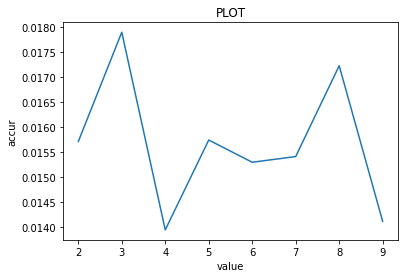

(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


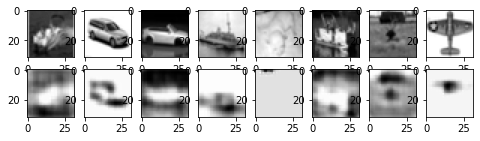

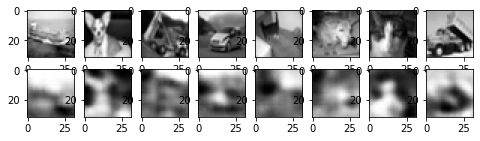

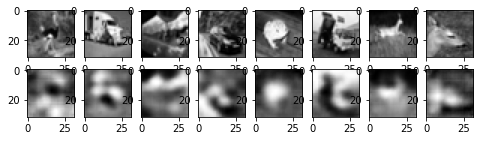

Reconstructed image


In [ ]:
# code and analysis here
class EncoderDecoder32(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder32,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
            nn.ReLU(),
            nn.Conv2d(8, 6, kernel_size=4, stride=2, padding=1), #6*8*8
            nn.ReLU(),
            nn.Conv2d(6, 2, kernel_size=4, stride=2, padding=1), #2*4*4
            # nn.Flatten()
        )
        self.decoder = nn.Sequential(
            # nn.Unflatten(1, torch.Size([2,4,4])),
            nn.ConvTranspose2d(2, 6, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        # print("REACH"),
        encoded = self.encoder(img)
        # print("REACHED", encoded.shape),
        decoded = self.decoder(encoded)
        # print("REACHED VAL", decoded.shape)
        return decoded

        

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model32 = EncoderDecoder32().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model32.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs32 = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1,3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model32(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs32.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

outputs32 = np.array(outputs32)
lst1 = outputs32[2:, 0]
lst2 = outputs32[2:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(8, 2))
    imgs = outputs32[k][2].numpy()
    recon = outputs32[k][3].numpy()
    print(imgs.shape, recon.shape)
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.imshow(item[0])

images = outputs32[9][2]
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs = outputs32[9][3]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0162
Epoch:2, Loss:0.0157
Epoch:3, Loss:0.0171
Epoch:4, Loss:0.0155
Epoch:5, Loss:0.0134
Epoch:6, Loss:0.0130
Epoch:7, Loss:0.0102
Epoch:8, Loss:0.0127
Epoch:9, Loss:0.0080
Epoch:10, Loss:0.0119


(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


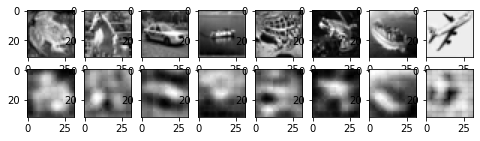

Reconstructed image


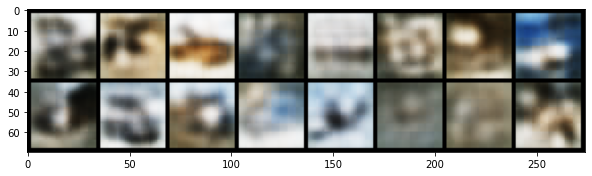

In [ ]:
# # code and analysis here
# class EncoderDecoder100(nn.Module):
#     # code
#     def __init__(self):
#         super(EncoderDecoder100,self).__init__() 
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
#             nn.ReLU(),
#             nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1), #6*8*8
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(16, 25, kernel_size=4, stride=2, padding=1), #2*4*4
#             nn.Flatten()
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, torch.Size([25,2,2])),
#             nn.ConvTranspose2d(25, 16, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             # nn.Unsamp(kernel_size=2, stride=2)
#             nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 3, kernel_size=4, stride=4, padding=0),
#             nn.Sigmoid(),
#         )

#     def forward(self,img):
#         # code here
#         encoded = self.encoder(img)
#         # print(encoded.shape)
#         decoded = self.decoder(encoded)
#         # print(decoded.shape)
#         return decoded


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model100 = EncoderDecoder100().to(device)
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model100.parameters(), lr=1e-3, weight_decay=1e-5)

# num_epochs = 10

# outputs100 = []
# loss = 0
# for epoch in range(num_epochs):
#     for (images, labels) in trainloader:
#       optimizer.zero_grad()
#       images = images.view(-1, 3,32,32).to(device)
#       # images = images.to(device)
#       labels = labels.to(device)
#       output = model100(images)
#       loss = loss_c(output, images)
#       loss.backward()
#       optimizer.step()

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs100.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

# outputs100 = np.array(outputs100)
# lst1 = outputs100[2:, 0]
# lst2 = outputs100[2:, 1]

# plt.plot(lst1, lst2)
# plt.ylabel('accur')
# plt.xlabel('value')
# plt.title('PLOT')
# plt.show()

# for k in range(0, num_epochs, 4):
#     plt.figure(figsize=(8, 2))
#     imgs = outputs100[k][2].numpy()
#     recon = outputs100[k][3].numpy()
#     print(imgs.shape, recon.shape)
#     for i, item in enumerate(imgs):
#         if i >= 8: break
#         plt.subplot(2, 8, i+1)
#         plt.imshow(item[0])
            
#     for i, item in enumerate(recon):
#         if i >= 8: break
#         plt.subplot(2, 8, 9+i)
#         plt.imshow(item[0])

# images = outputs100[9][2]
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)
# print("Reconstructed image")
# decoded_imgs = outputs100[9][3]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0126
Epoch:2, Loss:0.0107
Epoch:3, Loss:0.0073
Epoch:4, Loss:0.0055
Epoch:5, Loss:0.0061
Epoch:6, Loss:0.0052
Epoch:7, Loss:0.0050
Epoch:8, Loss:0.0057
Epoch:9, Loss:0.0036
Epoch:10, Loss:0.0043


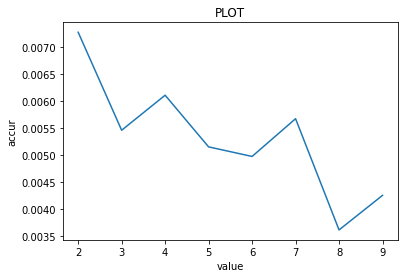

(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


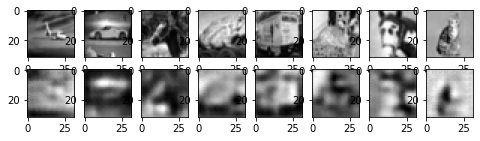

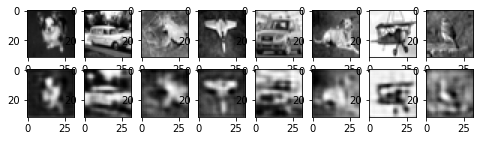

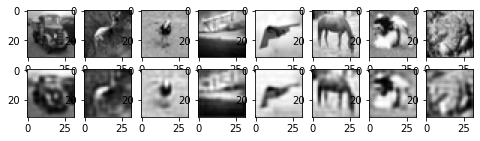

Reconstructed image


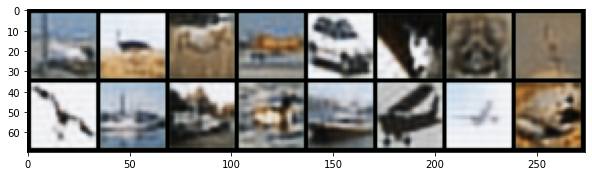

In [ ]:
# # code and analysis here
# class EncoderDecoder100(nn.Module):
#     # code
#     def __init__(self):
#         super(EncoderDecoder100,self).__init__() 
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
#             nn.ReLU(),
#             nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1), #6*8*8
#             nn.ReLU(),
#             nn.Conv2d(16, 25, kernel_size=4, stride=2, padding=1), #2*4*4
#             # nn.Flatten()
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, torch.Size([25,2,2])),
#             nn.ConvTranspose2d(25, 16, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self,img):
#         # code here
#         encoded = self.encoder(img)
#         # print(encoded.shape)
#         decoded = self.decoder(encoded)
#         # print(decoded.shape)
#         return decoded


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model100 = EncoderDecoder100().to(device)
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model100.parameters(), lr=1e-3, weight_decay=1e-5)

# num_epochs = 10

# outputs100 = []
# loss = 0
# for epoch in range(num_epochs):
#     for (images, labels) in trainloader:
#       optimizer.zero_grad()
#       images = images.view(-1, 3,32,32).to(device)
#       # images = images.to(device)
#       labels = labels.to(device)
#       output = model100(images)
#       loss = loss_c(output, images)
#       loss.backward()
#       optimizer.step()

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs100.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

# outputs100 = np.array(outputs100)
# lst1 = outputs100[2:, 0]
# lst2 = outputs100[2:, 1]

# plt.plot(lst1, lst2)
# plt.ylabel('accur')
# plt.xlabel('value')
# plt.title('PLOT')
# plt.show()

# for k in range(0, num_epochs, 4):
#     plt.figure(figsize=(8, 2))
#     imgs = outputs100[k][2].numpy()
#     recon = outputs100[k][3].numpy()
#     print(imgs.shape, recon.shape)
#     for i, item in enumerate(imgs):
#         if i >= 8: break
#         plt.subplot(2, 8, i+1)
#         plt.imshow(item[0])
            
#     for i, item in enumerate(recon):
#         if i >= 8: break
#         plt.subplot(2, 8, 9+i)
#         plt.imshow(item[0])

# images = outputs100[9][2]
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)
# print("Reconstructed image")
# decoded_imgs = outputs100[9][3]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# code and analysis here
class EncoderDecoder100(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder100,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), #8*16*16
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1), #6*8*8
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 25, kernel_size=4, stride=2, padding=1), #2*4*4
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([25,2,2])),
            nn.ConvTranspose2d(25, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # nn.Unsamp(kernel_size=2, stride=2)
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=4, padding=0),
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        # print(decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model100 = EncoderDecoder100().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model100.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10

outputs100 = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      images = images.view(-1, 3,32,32).to(device)
      # images = images.to(device)
      labels = labels.to(device)
      output = model100(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs100.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

outputs100 = np.array(outputs100)
lst1 = outputs100[2:, 0]
lst2 = outputs100[2:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(8, 2))
    imgs = outputs100[k][2].numpy()
    recon = outputs100[k][3].numpy()
    print(imgs.shape, recon.shape)
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.imshow(item[0])

images = outputs100[9][2]
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs = outputs100[9][3]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0158
Epoch:2, Loss:0.0147
Epoch:3, Loss:0.0092
Epoch:4, Loss:0.0074
Epoch:5, Loss:0.0070
Epoch:6, Loss:0.0080
Epoch:7, Loss:0.0076
Epoch:8, Loss:0.0071
Epoch:9, Loss:0.0071
Epoch:10, Loss:0.0057


(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


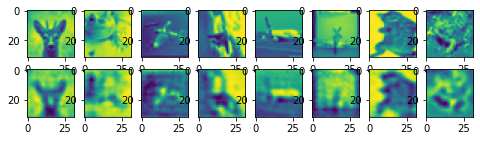

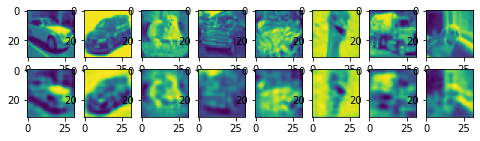

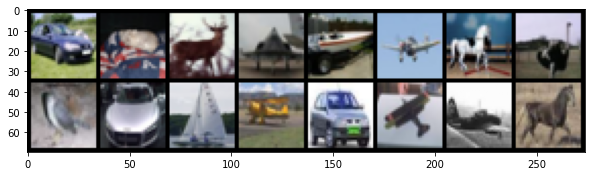

Reconstructed image


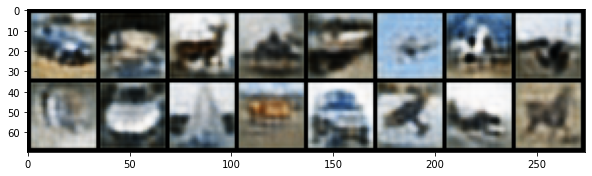

In [ ]:

# code and analysis here
class EncoderDecoder1000(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder1000,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), # (32-4+2)/2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), # (16-4)/2 + 1 = 7 
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 40, kernel_size=3, stride=1), # (7-3)/1 + 1
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([40,5,5])),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(25, 16, kernel_size=3, stride=2, padding=1), # (32-3+2)/2 + 1
            nn.ConvTranspose2d(40, 16, kernel_size=3, stride=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1), # (32-3+2)/2 + 1
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1000 = EncoderDecoder1000().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model1000.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs10000 = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model1000(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs10000.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

outputs10000 = np.array(outputs10000)
lst1 = outputs10000[:, 0]
lst2 = outputs10000[:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(8, 2))
    imgs = outputs10000[k][2].numpy()
    recon = outputs10000[k][3].numpy()
    print(imgs.shape, recon.shape)
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.imshow(item[0])

images = outputs10000[9][2]
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs = outputs10000[9][3]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

NOTE I ASSUMED WE CAN HAVE ANY SIZE OF REPRESENTATION LAYER

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

Reconstructed image


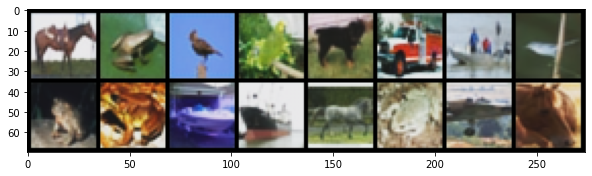

In [ ]:
# code and analysis here
class EncoderDecoder_1_layer(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder_1_layer,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1), # (32-4+2)/2 + 1 = 16
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([8,16,16])),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1), # (32-3+2)/2 + 1
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1_layer = EncoderDecoder_1_layer().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_layer.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs_1_layer = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model_1_layer(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_1_layer.append((epoch,  images, output))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    imgs = outputs_1_layer[k][1].cpu().detach().numpy()
    recon = outputs_1_layer[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) 
        plt.imshow(item[0].T)

images = outputs_1_layer[9][1].cpu().detach()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs =  outputs_1_layer[9][2].cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0006
Epoch:2, Loss:0.0003
Epoch:3, Loss:0.0003
Epoch:4, Loss:0.0002
Epoch:5, Loss:0.0002
Epoch:6, Loss:0.0002
Epoch:7, Loss:0.0002
Epoch:8, Loss:0.0003
Epoch:9, Loss:0.0001
Epoch:10, Loss:0.0001


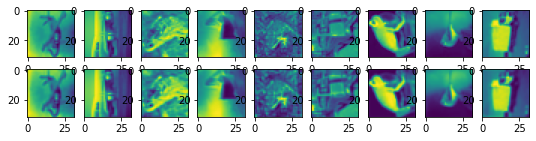

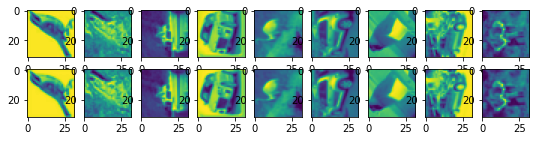

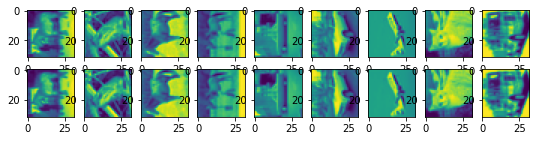

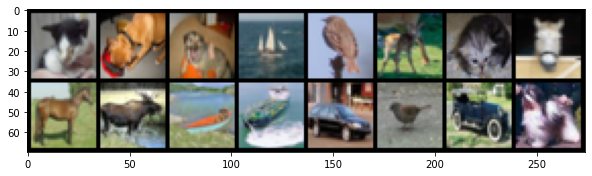

Reconstructed image


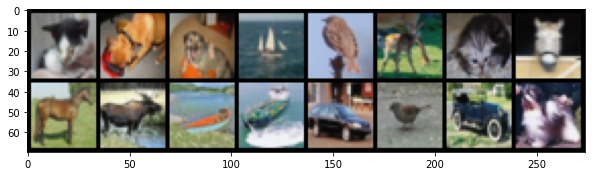

In [ ]:
# code and analysis here
class EncoderDecoder_3_layer(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder_3_layer,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1), # (32-4+2)/2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 24, kernel_size=2, stride=1, padding=1), # (16-4)/2 + 1 = 7 
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 72, kernel_size=2,  stride=1, padding=1), # (7-3)/1 + 1
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([72,35,35])),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(25, 16, kernel_size=3, stride=2, padding=1), # (32-3+2)/2 + 1
            nn.ConvTranspose2d(72, 24, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(24, 8, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 3, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3_layer = EncoderDecoder_3_layer().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model_3_layer.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs_3_layer = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model_3_layer(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_3_layer.append((epoch,  images, output))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    imgs = outputs_3_layer[k][1].cpu().detach().numpy()
    recon = outputs_3_layer[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) 
        plt.imshow(item[0].T)

images = outputs_3_layer[9][1].cpu().detach()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs =  outputs_3_layer[9][2].cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0005
Epoch:2, Loss:0.0003
Epoch:3, Loss:0.0003
Epoch:4, Loss:0.0006
Epoch:5, Loss:0.0002
Epoch:6, Loss:0.0003
Epoch:7, Loss:0.0001
Epoch:8, Loss:0.0001
Epoch:9, Loss:0.0004
Epoch:10, Loss:0.0001


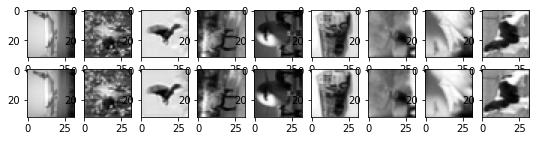

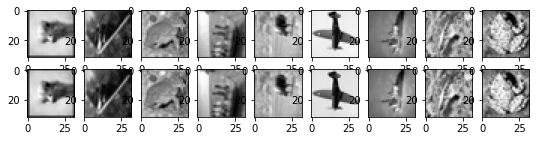

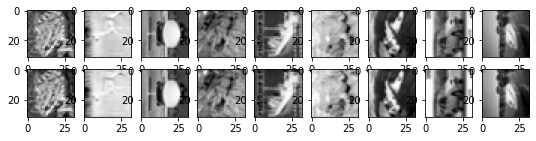

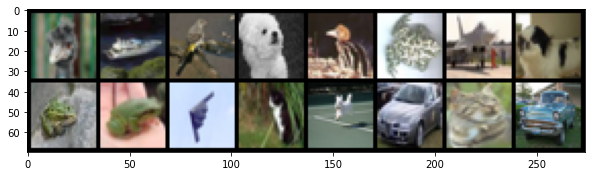

Reconstructed image


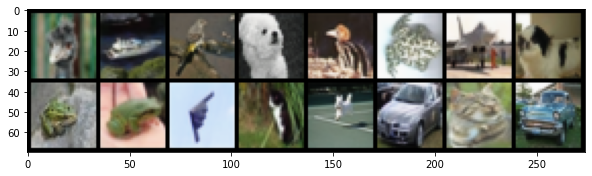

In [ ]:
# code and analysis here
class EncoderDecoder_5_layer(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder_5_layer,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1), # (32-4+2)/2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 24, kernel_size=2, stride=1, padding=1), # (16-4)/2 + 1 = 7 
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 72, kernel_size=2,  stride=1, padding=1), # (7-3)/1 + 1
            nn.ReLU(inplace=True),
            nn.Conv2d(72, 216, kernel_size=2,  stride=1, padding=1), # (7-3)/1 + 1
            nn.ReLU(inplace=True),
            nn.Conv2d(216, 512, kernel_size=2,  stride=1, padding=1), # (7-3)/1 + 1
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([512,37,37])),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.ConvTranspose2d(25, 16, kernel_size=3, stride=2, padding=1), # (32-3+2)/2 + 1
            nn.ConvTranspose2d(512, 216, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            nn.ConvTranspose2d(216, 72, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            nn.ConvTranspose2d(72, 24, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(24, 8, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 3, kernel_size=2, stride=1, padding=1), # (32-3+2)/2 + 1
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_5_layer = EncoderDecoder_5_layer().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model_5_layer.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs_5_layer = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model_5_layer(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_5_layer.append((epoch,  images, output))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    imgs = outputs_5_layer[k][1].cpu().detach().numpy()
    recon = outputs_5_layer[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) 
        plt.imshow(item[0].T)

images = outputs_5_layer[9][1].cpu().detach()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs =  outputs_5_layer[9][2].cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0573
Epoch:2, Loss:0.0694
Epoch:3, Loss:0.0649
Epoch:4, Loss:0.0714
Epoch:5, Loss:0.0546
Epoch:6, Loss:0.0631
Epoch:7, Loss:0.0553
Epoch:8, Loss:0.0588
Epoch:9, Loss:0.0479
Epoch:10, Loss:0.0595


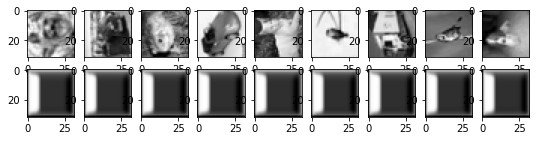

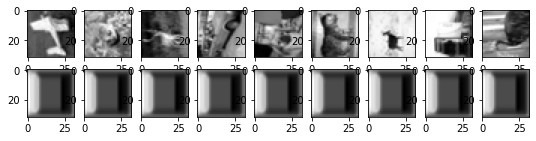

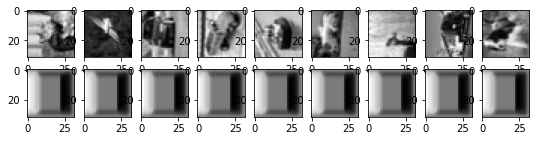

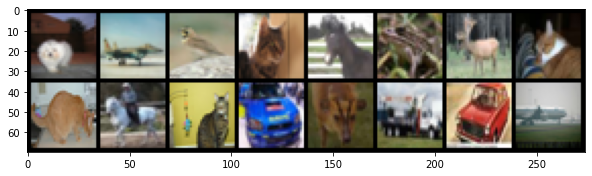

Reconstructed image


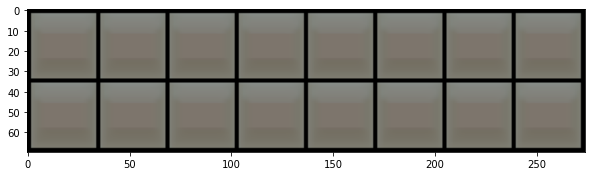

In [ ]:
# code and analysis here
class EncoderDecoder_10_layer(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder_10_layer,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 8, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 12, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 15, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 15, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 18, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(18, 21, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 24, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 24, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 25, kernel_size=2,  stride=1),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([25, 22, 22])),
            nn.ConvTranspose2d(25, 24, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 24, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 21, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(21, 18, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(18, 15, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 15, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 12, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 8, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=2, stride=1), 
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_10_layer = EncoderDecoder_10_layer().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model_10_layer.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs_10_layer = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model_10_layer(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_10_layer.append((epoch,  images, output))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    imgs = outputs_10_layer[k][1].cpu().detach().numpy()
    recon = outputs_10_layer[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) 
        plt.imshow(item[0].T)

images = outputs_10_layer[9][1].cpu().detach()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs =  outputs_10_layer[9][2].cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0566
Epoch:2, Loss:0.0564
Epoch:3, Loss:0.0675
Epoch:4, Loss:0.0672
Epoch:5, Loss:0.0525
Epoch:6, Loss:0.0676
Epoch:7, Loss:0.0724
Epoch:8, Loss:0.0615
Epoch:9, Loss:0.0631
Epoch:10, Loss:0.0520


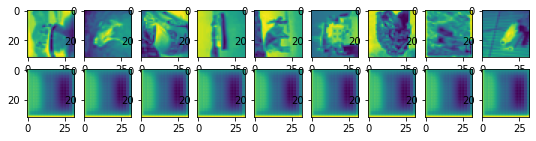

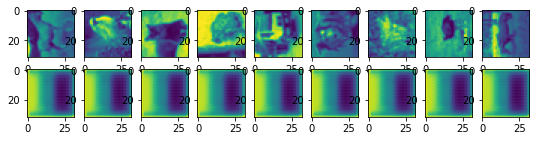

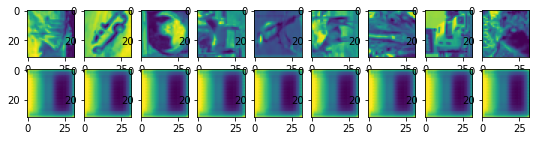

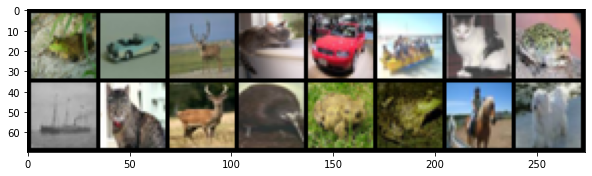

Reconstructed image


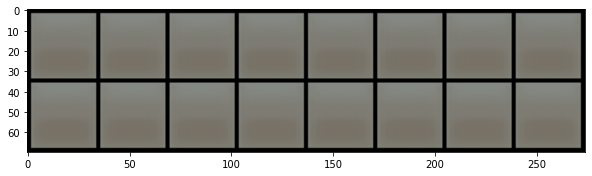

In [ ]:
# code and analysis here
class EncoderDecoder_10_layer(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder_10_layer,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 8, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 12, kernel_size=2,  stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 15, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 15, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 18, kernel_size=2,  stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(18, 21, kernel_size=2,  stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 24, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 24, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 25, kernel_size=2,  stride=2),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([25,2,2])),
            nn.ConvTranspose2d(25, 24, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 24, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 21, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(21, 18, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(18, 15, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 15, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 12, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 8, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 6, kernel_size=2, stride=1), 
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 3, kernel_size=2, stride=1), 
            nn.Sigmoid(),
        )

    def forward(self,img):
        # code here
        encoded = self.encoder(img)
        # print("ENC :", encoded.shape)
        decoded = self.decoder(encoded)
        # print("DEC :", decoded.shape)
        return decoded


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_10_layer = EncoderDecoder_10_layer().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model_10_layer.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs_10_layer = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1, 3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      output = model_10_layer(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_10_layer.append((epoch,  images, output))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    imgs = outputs_10_layer[k][1].cpu().detach().numpy()
    recon = outputs_10_layer[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) 
        plt.imshow(item[0].T)

images = outputs_10_layer[9][1].cpu().detach()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs =  outputs_10_layer[9][2].cpu().detach()
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
"""In 1,3,5 layers i got decent loss and ithe reconstructed images was pretty clear but in 10 layers i got close to no accuracy and imae reconstruction"""

'In 1,3,5 layers i got decent loss and ithe reconstructed images was pretty clear but in 10 layers i got close to no accuracy and imae reconstruction'

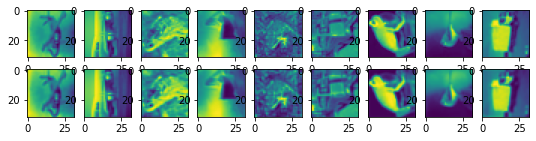

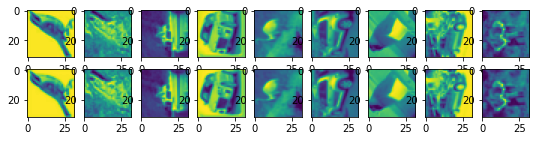

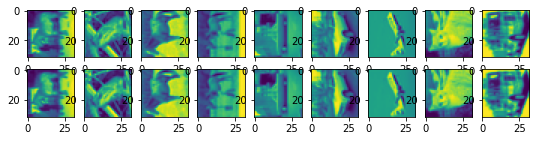

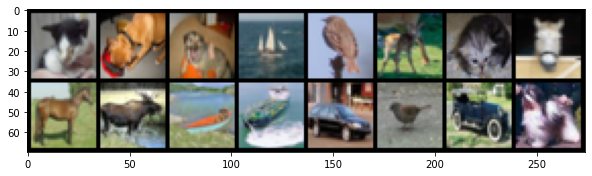

Reconstructed image


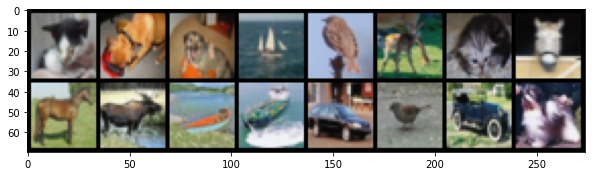

In [ ]:
# # code and analysis here
# class EncoderDecoder_10_layer(nn.Module):
#     # code
#     def __init__(self):
#         super(EncoderDecoder_10_layer,self).__init__() 
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(16, 24, kernel_size=2,  stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(24, 32, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 40, kernel_size=2,  stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(40, 48, kernel_size=2,  stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(48, 56, kernel_size=2,  stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(56, 64, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 72, kernel_size=2, stride=1, padding=1), 
#             nn.ReLU(inplace=True),
#             nn.Conv2d(72, 80, kernel_size=2,  stride=2, padding=1),
#             nn.Flatten()
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, torch.Size([80,7,7])),
#             nn.ConvTranspose2d(80, 72, kernel_size=2, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(72, 64, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 56, kernel_size=2, stride=1, padding=1), 
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(56, 48, kernel_size=2, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(48, 40, kernel_size=3, stride=1, padding=1), 
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(40, 32, kernel_size=2, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(32, 24, kernel_size=3, stride=1, padding=1), 
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(24, 16, kernel_size=2, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1), 
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(8, 3, kernel_size=3, stride=1, padding=1), 
#             nn.Sigmoid(),
#         )

#     def forward(self,img):
#         # code here
#         encoded = self.encoder(img)
#         # print("ENC :", encoded.shape)
#         decoded = self.decoder(encoded)
#         # print("DEC :", decoded.shape)
#         return decoded


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_10_layer = EncoderDecoder_10_layer().to(device)
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model_10_layer.parameters(), lr=1e-3, weight_decay=1e-5)

# num_epochs = 10
# outputs_10_layer = []
# loss = 0
# for epoch in range(num_epochs):
#     for (images, labels) in trainloader:
#       optimizer.zero_grad()
#       # images = images.view(-1, 3,32,32).to(device)
#       images = images.to(device)
#       labels = labels.to(device)
#       output = model_10_layer(images)
#       loss = loss_c(output, images)
#       loss.backward()
#       optimizer.step()

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs_10_layer.append((epoch,  images, output))

# for k in range(0, num_epochs, 4):
#     plt.figure(figsize=(9, 2))
#     imgs = outputs_10_layer[k][1].cpu().detach().numpy()
#     recon = outputs_10_layer[k][2].cpu().detach().numpy()
#     for i, item in enumerate(imgs):
#         if i >= 9: break
#         plt.subplot(2, 9, i+1)
#         plt.imshow(item[0].T)
            
#     for i, item in enumerate(recon):
#         if i >= 9: break
#         plt.subplot(2, 9, 9+i+1) 
#         plt.imshow(item[0].T)

# images = outputs_10_layer[9][1].cpu().detach()
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)
# print("Reconstructed image")
# decoded_imgs =  outputs_10_layer[9][2].cpu().detach()
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

PCA and t-SNE are linear and nonlinear dimensionality reduction techniques, respectively, which aim to reduce the number of input features while preserving the most significant information. Here we reduce dimension by removing non necessary dimensions or gathering necessary information.

Autoencoder are used unsupervised learning tasks like data compression, feature extraction etc. Autoencoders learns input data by encoding it into a lower-dimensional space and then decoding back to original input space. Neural netwroks are also non linear but can learn more complex data so they can learn better than both of above techniques.

on this dataset i acheived the best results in 1,3,5 layers but as the no of layers inceases the model was not able to learn the input data much.
Also model was very slow in training as the layers were increasing.


## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

Epoch:1, Loss:0.0402
Epoch:2, Loss:0.0267
Epoch:3, Loss:0.0267
Epoch:4, Loss:0.0272
Epoch:5, Loss:0.0269
Epoch:6, Loss:0.0290
Epoch:7, Loss:0.0327
Epoch:8, Loss:0.0327
Epoch:9, Loss:0.0246
Epoch:10, Loss:0.0254


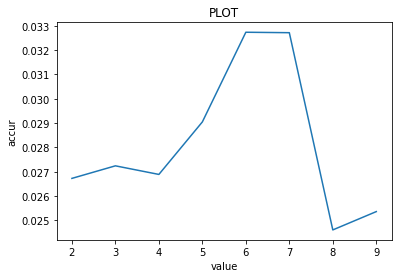

(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


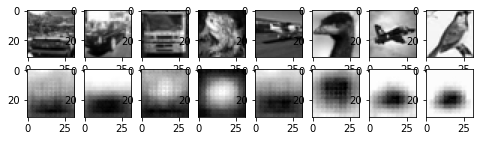

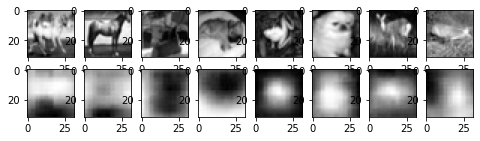

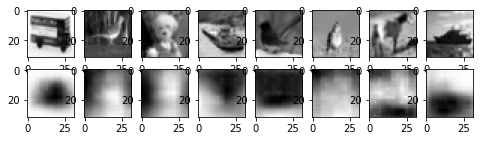

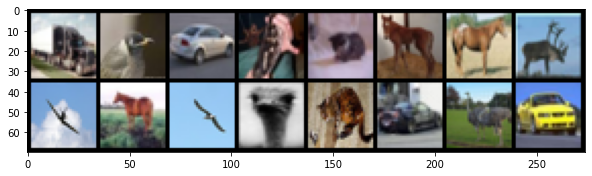

Reconstructed image


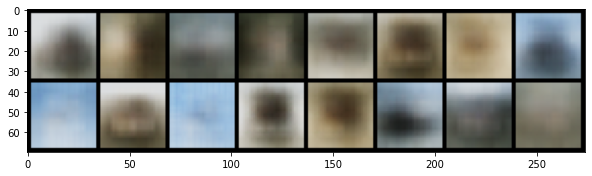

In [ ]:
# # code and analysis here. Remember to keep your analysis of high quality at all times.
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score, f1_score

# class EncoderDecoder10(nn.Module):
#     # code
#     def __init__(self):
#         super(EncoderDecoder10,self).__init__() 
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 9, kernel_size=2, stride=3),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(9, 27, kernel_size=6, stride=1), 
#             nn.ReLU(inplace=True),
#             nn.Conv2d(27, 10, kernel_size=3, stride=3), 
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 1),
#             nn.Flatten(),
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, torch.Size([10,1,1])),
#             # nn.MaxUnpool2d(2, 1),
#             nn.ConvTranspose2d(10, 27, kernel_size=4, stride=3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(27, 9, kernel_size=4, stride=3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(9, 3, kernel_size=4, stride=3, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self,img):
#         # code here
#         # print("REACH"),
#         encoded = self.encoder(img)
#         # print("REACHED", encoded.shape),
#         decoded = self.decoder(encoded)
#         # print("REACHED VAL", decoded.shape)
#         return encoded, decoded

    
    

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model10 = EncoderDecoder10().to(device)
# loss_c = nn.MSELoss()
# optimizer = torch.optim.Adam(model10.parameters(), lr=1e-3, weight_decay=1e-5)

# num_epochs = 10
# outputs10 = []
# loss = 0
# encoded = 0
# for epoch in range(num_epochs):
#     for (images, labels) in trainloader:
#       optimizer.zero_grad()
#       # images = images.view(-1,3,32,32).to(device)
#       images = images.to(device)
#       labels = labels.to(device)
#       encoded, output = model10(images)
#       loss = loss_c(output, images)
#       loss.backward()
#       optimizer.step()

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs10.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

# outputs10 = np.array(outputs10)
# lst1 = outputs10[2:, 0]
# lst2 = outputs10[2:, 1]

# plt.plot(lst1, lst2)
# plt.ylabel('accur')
# plt.xlabel('value')
# plt.title('PLOT')
# plt.show()

# for k in range(0, num_epochs, 4):
#     plt.figure(figsize=(8, 2))
#     imgs = outputs10[k][2].numpy()
#     recon = outputs10[k][3].numpy()
#     print(imgs.shape, recon.shape)
#     for i, item in enumerate(imgs):
#         if i >= 8: break
#         plt.subplot(2, 8, i+1)
#         plt.imshow(item[0])
            
#     for i, item in enumerate(recon):
#         if i >= 8: break
#         plt.subplot(2, 8, 9+i)F
#         plt.imshow(item[0])

# images = outputs10[9][2]
# # print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)
# print("Reconstructed image")
# decoded_imgs = outputs10[9][3]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

Epoch:1, Loss:0.0309
Epoch:2, Loss:0.0276
Epoch:3, Loss:0.0336
Epoch:4, Loss:0.0320
Epoch:5, Loss:0.0270
Epoch:6, Loss:0.0280
Epoch:7, Loss:0.0300
Epoch:8, Loss:0.0307
Epoch:9, Loss:0.0277
Epoch:10, Loss:0.0337


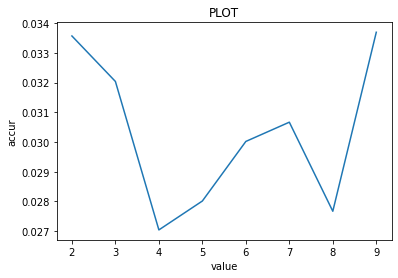

(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)
(16, 3, 32, 32) (16, 3, 32, 32)


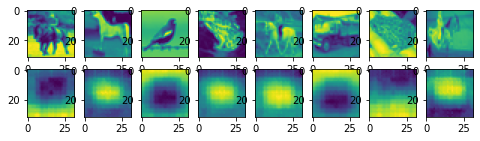

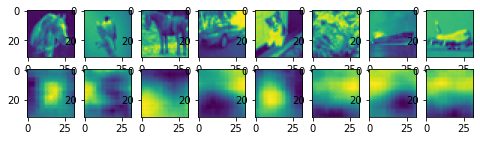

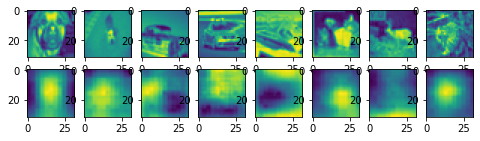

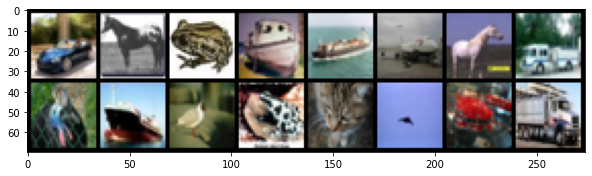

Reconstructed image


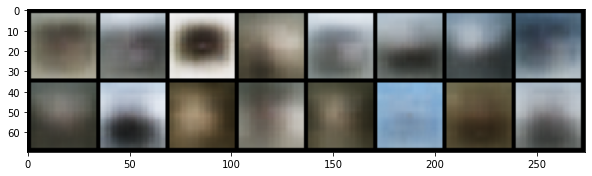

In [ ]:
# code and analysis here. Remember to keep your analysis of high quality at all times.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

class EncoderDecoder10(nn.Module):
    # code
    def __init__(self):
        super(EncoderDecoder10,self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 9, kernel_size=2, stride=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(9, 27, kernel_size=6, stride=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(27, 10, kernel_size=3, stride=3), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 1),
            nn.Flatten(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([10,1,1])),
            # nn.MaxUnpool2d(2, 1),
            nn.ConvTranspose2d(10, 27, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(27, 9, kernel_size=4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, kernel_size=4, stride=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self,img):
        # code here
        # print("REACH"),
        encoded = self.encoder(img)
        # print("REACHED", encoded.shape),
        decoded = self.decoder(encoded)
        # print("REACHED VAL", decoded.shape)
        return encoded, decoded

    
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model10 = EncoderDecoder10().to(device)
loss_c = nn.MSELoss()
optimizer = torch.optim.Adam(model10.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs10 = []
loss = 0
encoded = 0
for epoch in range(num_epochs):
    for (images, labels) in trainloader:
      optimizer.zero_grad()
      # images = images.view(-1,3,32,32).to(device)
      images = images.to(device)
      labels = labels.to(device)
      encoded, output = model10(images)
      loss = loss_c(output, images)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs10.append((epoch, float(loss.item()), images.cpu().detach(), output.cpu().detach()))

outputs10 = np.array(outputs10)
lst1 = outputs10[2:, 0]
lst2 = outputs10[2:, 1]

plt.plot(lst1, lst2)
plt.ylabel('accur')
plt.xlabel('value')
plt.title('PLOT')
plt.show()

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(8, 2))
    imgs = outputs10[k][2].numpy()
    recon = outputs10[k][3].numpy()
    print(imgs.shape, recon.shape)
    for i, item in enumerate(imgs):
        if i >= 8: break
        plt.subplot(2, 8, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 8: break
        plt.subplot(2, 8, 9+i)
        plt.imshow(item[0])

images = outputs10[9][2]
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
print("Reconstructed image")
decoded_imgs = outputs10[9][3]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
train_x_np =np.array(train_x)
test_x_np =np.array(test_x)

y_train = train_x_np[:, 1].flatten()
y_test = test_x_np[:, 1].flatten()
# encoded, output = model10(images)

# x_train_encoded = encoded.predict(train_x[:, 0])
# x_test_encoded = encoded.predict(test_x[:, 0])


classifier = KNeighborsClassifier(n_neighbors=5)
images = []
labels = []
for (image, labe) in trainloader:
    images.append(model10(image.to(device))[0])
    labels.append(labe.to(device))



for image, lab in zip(images, labels):
    classifier.fit(image.view(-1, 10).cpu().detach().numpy(), lab.view(-1, 1).cpu().detach().numpy())
# classifier.fit(images.view(-1, 3, 32, 32), labels.view(-1, 1))

i=0
lst = 0

images = []
labels = []
for (imag, label) in testloader:
    images.append(model10(imag.to(device))[0])
    labels.append(label.to(device))
    
lst1 = []
lst2 = []    
for image, label in zip(images, labels):
    # y_pred = classifier.predict(model10(image.view(-1, 10).cpu().detach().numpy()))
    y_pred = classifier.predict(image.view(-1, 10).cpu().detach().numpy())
    # accuracy = accuracy_score(y_pred, label.cpu().detach().numpy())

    lst1.extend(y_pred)
    lst2.extend(label.cpu().detach().numpy())
    # lst += accuracy
    # # f1 = f1_score(lab, y_pred, average='weighted')
    # i+=1
    # print('F1 score:', f1)

print('Accuracy :', accuracy_score(lst1, lst2))
# print("F1 Score :", f1_score(lst2, lst2, average='weighted')

Accuracy: 0.18600716560509553


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    # plt.gray()
    real_img = outputs[k][1].cpu().detach().numpy()
    created = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(real_img):
        if i >= 9: break
        # print(item.shape)
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0].T)
            
    for i, item in enumerate(created):
        print(item.shape)
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0].T)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."

In [ ]:
# # sample code for a autoencoder:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 32, 32]
#         # Output size: [batch, 3, 32, 32]
#         # Representation size: 3072
#         # Number of Layers for encoder: 1
#         # Number of Layers for decoder: 1
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
#             nn.ReLU(),
#             nn.Flatten(), # 12x16x16 -> 3072
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
#             nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
num_epochs = 10
outputs = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in testloader:
      optimizer.zero_grad()
      images = images.to(device)
      # print(images.shape)
      labels = labels.to(device)
      output = modelCNN(images)
      # print(output.size(), labels.size(), output.dtype, labels.dtype)
      loss = loss_c(output, images)
      # print(loss.dtype)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch,  images, output))

In [ ]:
# autoenc
num_epochs = 10
outputs = []
loss = 0
for epoch in range(num_epochs):
    for (images, labels) in testloader:
      optimizer.zero_grad()
      images = images.to(device)
      # print(images.shape)
      labels = labels.to(device)
      output = autoenc(images)
      # print(output.size(), labels.size(), output.dtype, labels.dtype)
      loss = loss_c(output, images)
      # print(loss.dtype)
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch,  images, output))

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 3, 32, 32) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0].T)
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 3, 32, 32) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0].T)